In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

In [3]:
def torso_coordinate_modifier(torso_coordinate, shot_coordinate):
    distance = shot_coordinate - torso_coordinate
    torso_coordinate += distance * 0.2
    return torso_coordinate

In [4]:
def generate_torso_position(shot_coordinates, base_torso_coordinates=None):
    if base_torso_coordinates is None:
        base_torso_coordinates = [13, 15]

    torso = {
        "x": torso_coordinate_modifier(base_torso_coordinates[0], shot_coordinates[0]),
        "y": torso_coordinate_modifier(base_torso_coordinates[1], shot_coordinates[1])
    }
    return torso

In [5]:
generate_torso_position([0, 27])

{'x': 10.4, 'y': 17.4}

In [6]:
def generate_head_position(torso):
    head = {
        "x": torso["x"] + rng.normal(0, 0.2),
        "y": torso["y"] + 2.5 + rng.uniform(-0.3,0.1)
    }
    return head

In [7]:
generate_head_position(generate_torso_position([0, 27]))

{'x': 10.415955273848931, 'y': 19.72249529913}

In [8]:
LIMB_LENGTHS = {
    "upper_arm": 3.5,
    "forearm": 3.0,
    "thigh": 6.0,
    "shin": 4.5
}

JOINT_LIMITS = {
    "shoulder": (-90, 90),
    "elbow": (0, 150),
    "hip": (-90, 90),
    "knee": (0, 150)
}

In [9]:
def place_arm_toward_target(shoulder_coordinates, target_coordinates, region="center"):
    max_reach = LIMB_LENGTHS["upper_arm"] + LIMB_LENGTHS["forearm"]

    dx = target_coordinates[0] - shoulder_coordinates["x"]
    dy = target_coordinates[1] - shoulder_coordinates["y"]
    distance = np.sqrt(dx**2 + dy**2)

    if distance > max_reach:
        reach_factor = max_reach * 0.95
    else:
        reach_factor = distance * rng.uniform(0.85, 0.98)
    
    hand = {
            "x": shoulder_coordinates["x"] + (dx / distance) * reach_factor,
            "y": shoulder_coordinates["y"] + (dy / distance) * reach_factor
        }
    
    elbow = calculate_elbow_position(
        shoulder_coordinates,
        hand,
        LIMB_LENGTHS["upper_arm"],
        LIMB_LENGTHS["forearm"],
        region
    )

    return elbow, hand

def calculate_elbow_position(shoulder, hand, upper_arm_length, forearm_length, region):
    dx = hand["x"] - shoulder["x"]
    dy = hand["y"] - shoulder["y"]
    distance = np.sqrt(dx**2 + dy**2)

    distance = min(distance, upper_arm_length + forearm_length - 0.1)

    cos_elbow = (upper_arm_length**2 + forearm_length**2 - distance**2) / (2 * upper_arm_length * forearm_length)
    cos_elbow = np.clip(cos_elbow, -1, 1)
    #elbow_angle = np.arccos(cos_elbow)

    baseline_angle = np.arctan2(dy, dx)

    cos_shoulder = (upper_arm_length**2 + distance**2 - forearm_length**2) / (2 * upper_arm_length * distance)
    cos_shoulder = np.clip(cos_shoulder, -1, 1)
    shoulder_angle = np.arccos(cos_shoulder)

    if region == "right":
        elbow_direction = baseline_angle - shoulder_angle
    else:
        elbow_direction = baseline_angle + shoulder_angle

    elbow = {
        "x": shoulder["x"] + upper_arm_length * np.cos(elbow_direction),
        "y": shoulder["y"] + upper_arm_length * np.sin(elbow_direction)
    }

    return elbow

In [10]:
def place_balance_arm(shoulder_coordinates, torso, region):
    target_coordinates = [0, 0]

    if region == "right":
        target_coordinates[0] = shoulder_coordinates["x"] + 3
    else:
        target_coordinates[0] = shoulder_coordinates["x"] - 3

    target_coordinates[1] = torso["y"] + rng.uniform(-1, 2)

    elbow, hand = place_arm_toward_target(shoulder_coordinates, target_coordinates, region)
    return elbow, hand      

In [18]:
def place_leg_toward_target(hip_coordinates, target_coordinates, region="right"):
    max_reach = LIMB_LENGTHS["thigh"] + LIMB_LENGTHS["shin"]

    dx = target_coordinates[0] - hip_coordinates["x"]
    dy = target_coordinates[1] - hip_coordinates["y"]
    distance = np.sqrt(dx**2 + dy**2)

    if distance > max_reach:
        reach_factor = max_reach * 0.95
    else:
        reach_factor = distance * rng.uniform(0.85, 0.98)
    
    foot = {
            "x": hip_coordinates["x"] + (dx / distance) * reach_factor,
            "y": hip_coordinates["y"] + (dy / distance) * reach_factor
        }
    
    knee = calculate_knee_position(
        hip_coordinates,
        foot,
        LIMB_LENGTHS["thigh"],
        LIMB_LENGTHS["shin"],
        region
    )

    return knee, foot

def calculate_knee_position(hip, foot, thigh_length, shin_length, region):
    dx = foot["x"] - hip["x"]
    dy = foot["y"] - hip["y"]
    distance = np.sqrt(dx**2 + dy**2)

    distance = np.clip(distance, abs(thigh_length - shin_length) + 1e-6,
                   thigh_length + shin_length - 1e-6)
    
    x = (thigh_length**2 - shin_length**2 + distance**2) / (2 * distance)

    h_sq = thigh_length**2 - x**2
    h = np.sqrt(max(h_sq, 0.0))

    ux = dx / distance
    uy = dy / distance

    px = -uy
    py = ux

    if region == "right":
        sign = 1
    else:
        sign = -1

    '''
    distance = min(distance, thigh_length + shin_length - 0.1)

    cos_knee = (thigh_length**2 + shin_length**2 - distance**2) / (2 * thigh_length * shin_length)
    cos_knee = np.clip(cos_knee, -1, 1)
    knee_angle = np.arccos(cos_knee)

    baseline_angle = np.arctan2(dy, dx)

    cos_hip = (thigh_length**2 + distance**2 - shin_length**2) / (2 * thigh_length * distance)
    cos_hip = np.clip(cos_hip, -1, 1)
    hip_angle = np.arccos(cos_hip)

    if region == "right":
        knee_direction = baseline_angle + hip_angle
    else:
        knee_direction = baseline_angle - hip_angle

    knee = {
        "x": hip["x"] + thigh_length * np.cos(knee_direction),
        "y": hip["y"] + thigh_length * np.sin(knee_direction)
    }
    '''



    knee = {
        "x": hip["x"] + x * ux + sign * h * px,
        "y": hip["y"] + x * uy + sign * h * py
    }

    return knee

In [12]:
def place_supporting_leg(hip_coordinates, region="center"):
    target_coordinates = [0, 0]

    if region == "center":
        target_coordinates[0] = hip_coordinates["x"] + rng.uniform(-1, 1)
    elif region == "right":
        target_coordinates[0] = hip_coordinates["x"] + 2
    else:
        target_coordinates[0] = hip_coordinates["x"] - 2

    target_coordinates[1] = rng.uniform(0, 3)

    knee, foot = place_leg_toward_target(hip_coordinates, target_coordinates, region)
    return knee, foot

In [21]:
def generate_pose(shot_coordinates):
    torso = generate_torso_position(shot_coordinates)
    head = generate_head_position(torso)

    shoulder_horizontal_offset = 2
    shoulder_vertical_offset = 1.5
    left_shoulder = {"x": torso["x"] - shoulder_horizontal_offset, "y": torso["y"] + shoulder_vertical_offset}
    right_shoulder = {"x": torso["x"] + shoulder_horizontal_offset, "y": torso["y"] + shoulder_vertical_offset}

    hip_horizontal_offset = 1.5
    hip_vertical_offset = 3
    left_hip = {"x": torso["x"] - hip_horizontal_offset, "y": torso["y"] - hip_vertical_offset}
    right_hip = {"x": torso["x"] + hip_horizontal_offset, "y": torso["y"] - hip_vertical_offset}

    dx = shot_coordinates[0] - torso["x"]

    if shoulder_horizontal_offset > abs(dx):
        left_elbow, left_hand = place_arm_toward_target(left_shoulder, shot_coordinates, region="center")
        right_elbow, right_hand = place_arm_toward_target(right_shoulder, shot_coordinates, region="center")
        left_knee, left_foot = place_supporting_leg(left_hip, region="center")
        right_knee, right_foot = place_supporting_leg(right_hip, region="center")
    elif shot_coordinates[0] < torso["x"]:
        left_elbow, left_hand = place_arm_toward_target(left_shoulder, shot_coordinates, region="left")
        right_elbow, right_hand = place_balance_arm(right_shoulder, torso, region="right")
        left_knee, left_foot = place_leg_toward_target(left_hip, shot_coordinates, region="left")
        right_knee, right_foot = place_supporting_leg(right_hip, region="right")
    else:
        right_elbow, right_hand = place_arm_toward_target(right_shoulder, shot_coordinates, region="right")
        left_elbow, left_hand = place_balance_arm(left_shoulder, torso, region="left")
        right_knee, right_foot = place_leg_toward_target(right_hip, shot_coordinates, region="right")
        left_knee, left_foot = place_supporting_leg(left_hip, region="left")

    return {
        "torso": torso,
        "head": head,
        "left_shoulder": left_shoulder,
        "left_elbow": left_elbow,
        "left_hand": left_hand,
        "left_hip": left_hip,
        "left_knee": left_knee,
        "left_foot": left_foot,
        "right_shoulder": right_shoulder,
        "right_elbow": right_elbow,
        "right_hand": right_hand,
        "right_hip": right_hip,
        "right_knee": right_knee,
        "right_foot": right_foot
    }

In [30]:
# Convert pose to DataFrame for better visualization
pose = generate_pose([17, 13])
pose_df = pd.DataFrame(pose).T  # Transpose to have nodes as rows
pose_df.columns = ['x', 'y']
pose_df.index.name = 'node'
pose_df

,x,y
node,,
torso,13.800000,14.600000
head,14.045027,17.097041
left_shoulder,11.800000,16.100000
left_elbow,11.598979,12.605778
left_hand,9.122907,14.299610
left_hip,12.300000,11.600000
left_knee,9.100566,6.524212
left_foot,10.372451,2.207696
right_shoulder,15.800000,16.100000


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


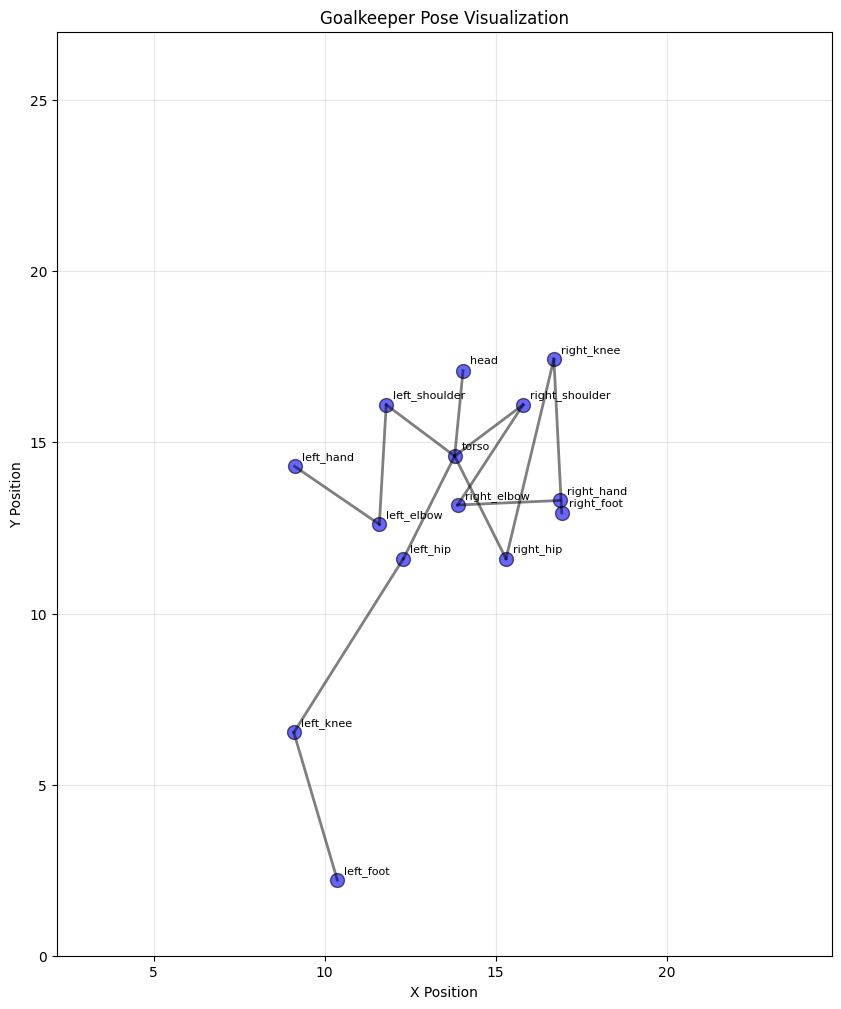

In [31]:
# Create scatter plot of the pose
plt.figure(figsize=(10, 12))
plt.scatter(pose_df['x'], pose_df['y'], s=100, c='blue', alpha=0.6, edgecolors='black')

# Label each node
for node, (x, y) in pose_df.iterrows():
    plt.annotate(node, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

# Draw skeleton connections
connections = [
    ('torso', 'head'),
    ('torso', 'left_shoulder'), ('torso', 'right_shoulder'),
    ('left_shoulder', 'left_elbow'), ('left_elbow', 'left_hand'),
    ('right_shoulder', 'right_elbow'), ('right_elbow', 'right_hand'),
    ('torso', 'left_hip'), ('torso', 'right_hip'),
    ('left_hip', 'left_knee'), ('left_knee', 'left_foot'),
    ('right_hip', 'right_knee'), ('right_knee', 'right_foot')
]

for node1, node2 in connections:
    x_vals = [pose_df.loc[node1, 'x'], pose_df.loc[node2, 'x']]
    y_vals = [pose_df.loc[node1, 'y'], pose_df.loc[node2, 'y']]
    plt.plot(x_vals, y_vals, 'k-', alpha=0.5, linewidth=2)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Goalkeeper Pose Visualization')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim(0, 27)
plt.ylim(0, 27)
plt.show()

# Graphs

In [16]:
# Generate data with initial and final torso positions
shot_data = []
initial_torso_data = []
final_torso_data = []

# Generate multiple shots
for _ in range(20):  # Generate 20 shots as example
    shot = [rng.uniform(0, 27), rng.uniform(0, 27)]
    initial_torso = [13, 15]
    
    # Generate final torso position
    final_torso = [initial_torso[0], initial_torso[1]]
    final_torso[0] = coordinate_modifier(final_torso[0], shot[0])
    final_torso[1] = coordinate_modifier(final_torso[1], shot[1])
    
    shot_data.append(shot)
    initial_torso_data.append(initial_torso)
    final_torso_data.append(final_torso)

# Create scatter plot
plt.figure(figsize=(10, 8))
shot_data = np.array(shot_data)
initial_torso_data = np.array(initial_torso_data)
final_torso_data = np.array(final_torso_data)

plt.scatter(shot_data[:, 0], shot_data[:, 1], label='Shot Coordinates', s=100, marker='*', color='red')
plt.scatter(initial_torso_data[:, 0], initial_torso_data[:, 1], label='Initial Torso', s=50, marker='o', color='blue')
plt.scatter(final_torso_data[:, 0], final_torso_data[:, 1], label='Final Torso', s=50, marker='^', color='green')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'coordinate_modifier' is not defined